In [29]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier


from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from jcopml.tuning import random_search_params as rsp, bayes_search_params as bsp
from jcopml.feature_importance import mean_score_decrease

In [2]:
df = pd.read_csv("data/Telco_Cusomer_Churn.csv", index_col="customerID")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

In [6]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

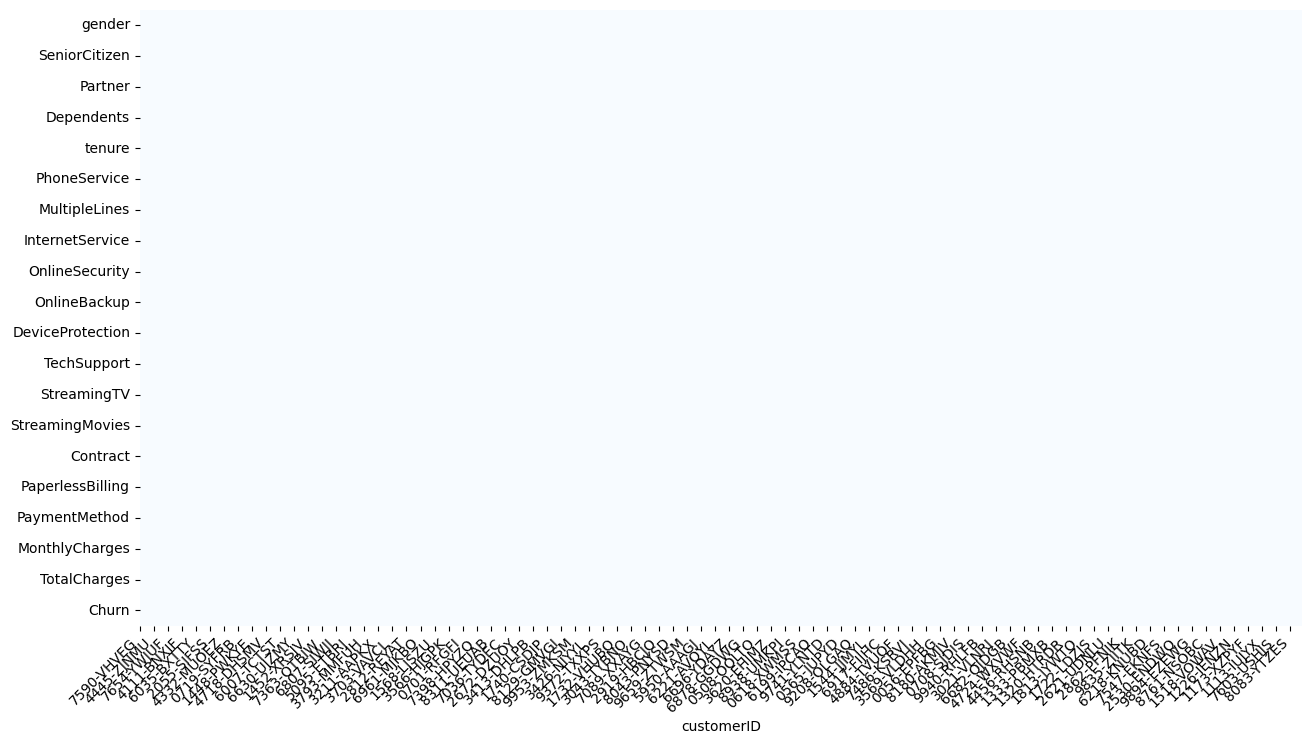

In [7]:
plot_missing_value(df)

In [6]:
df.SeniorCitizen.value_counts()


SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

### Dataset Splitting

In [3]:
X = df.drop(columns="Churn")
y = df.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((5634, 19), (1409, 19), (5634,), (1409,))

In [15]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
X_train[num_cols] = X_train[num_cols].apply(pd.to_numeric, errors='coerce')
X_test[num_cols] = X_test[num_cols].apply(pd.to_numeric, errors='coerce')

In [5]:
X_train.head(
    
)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
4950-BDEUX,Male,0,No,No,35,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,1701.65
7993-NQLJE,Male,0,Yes,Yes,15,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,75.10,1151.55
7321-ZNSLA,Male,0,Yes,Yes,13,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Mailed check,40.55,590.35
4922-CVPDX,Female,0,Yes,No,26,Yes,No,DSL,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),73.50,1905.7
2903-YYTBW,Male,0,Yes,Yes,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,44.55,44.55


In [4]:
X_train.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [23]:
prepocessor = ColumnTransformer([
    ("numeric", num_pipe(), ["tenure", "MonthlyCharges", "TotalCharges"]),
    ("categoric", cat_pipe(encoder="onehot"), ["gender", "SeniorCitizen", "Partner", "PhoneService", "MultipleLines", "InternetService",
                                              "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
                                              "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod"])
])

pipeline = Pipeline([
    ("prep", prepocessor),
    ("algo", RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, n_iter=100, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_estimator_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
      

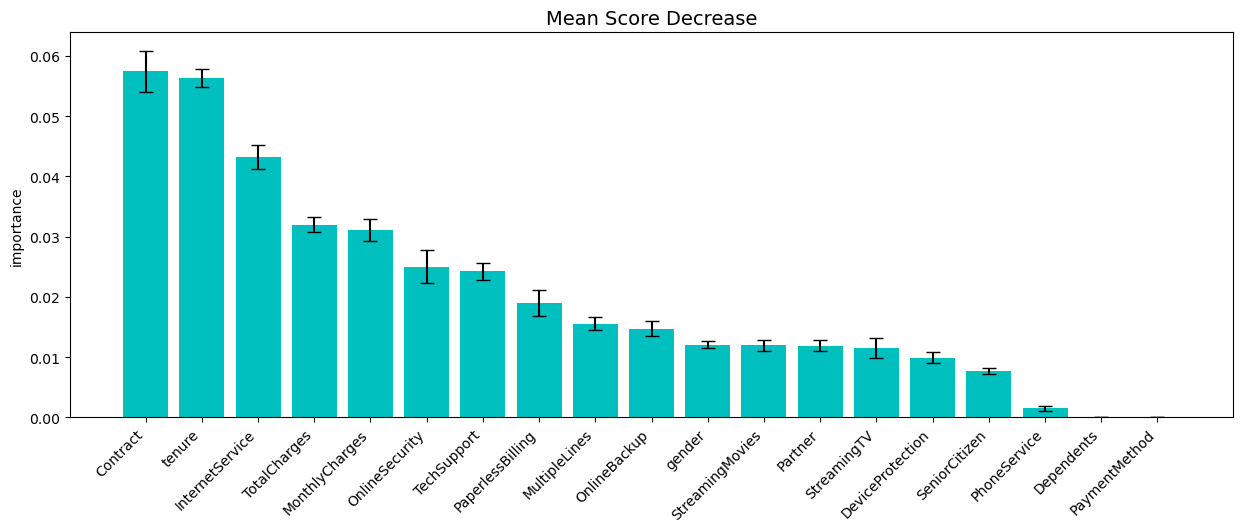

In [21]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)

In [36]:
prepocessor = ColumnTransformer([
    ("numeric", num_pipe(), ["tenure", "MonthlyCharges", "TotalCharges"]),
    ("categoric", cat_pipe(encoder="onehot"), ["gender", "SeniorCitizen", "Partner", "MultipleLines", "InternetService",
                                              "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
                                              "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod"])
])

pipeline = Pipeline([
    ("prep", prepocessor),
    ("algo", RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, n_iter=100, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_estimator_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
      